Train hasta 2024-07-12 12:00:00 (57104 muestras)
Val   2024-07-12 12:00:00–2024-12-08 05:00:00 (7138 muestras)
Test  2024-12-08 05:00:00–2025-05-05 23:30:00 (7138 muestras)
Features seleccionadas: ['hour', 'dayofweek', 'is_weekend', 'off_lag_1', 'off_lag_48', 'off_lag_336', 'off_roll_mean_48', 'off_roll_std_48', 'off_roll_std_336', 'sin_daily_1', 'sin_daily_2', 'cos_daily_1', 'sin_weekly_1']

Evolución mensual del error (test):
     month        MAE       RMSE
0  2024-12  27.576642  54.613073
1  2025-01  25.695511  43.258364
2  2025-02  40.164297  71.917077
3  2025-03  35.172296  50.412100
4  2025-04  31.583332  52.432393
5  2025-05  18.956981  27.537735


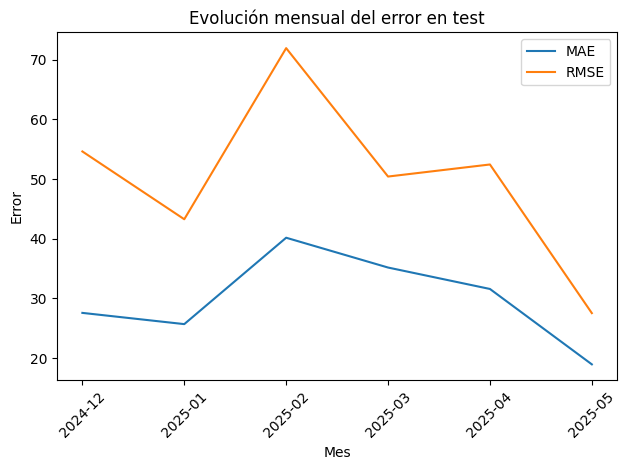

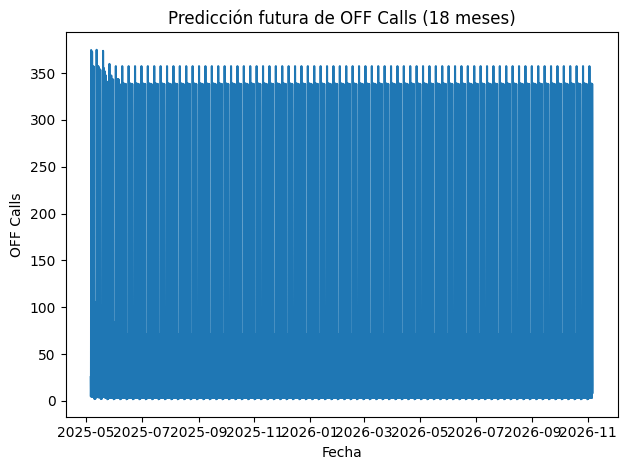


Predicciones futuras guardadas en C:/Users/nicol/OneDrive/Escritorio/forecast/data_jam.csv/predictions_future.xlsx


In [3]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# 1) Carga y parsing de fechas (meses en español)
df_raw = pd.read_csv(r'C:\Users\nicol\OneDrive\Escritorio\forecast\data_jam.csv')
month_map = {
    'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4,
    'mayo': 5, 'junio': 6, 'julio': 7, 'agosto': 8,
    'septiembre': 9, 'octubre': 10, 'noviembre': 11, 'diciembre': 12
}
df_raw['mes_num'] = df_raw['DATE_S - Mes'].str.lower().map(month_map)
df_raw['date'] = pd.to_datetime(
    df_raw['DATE_S - Año'].astype(str) + '-' +
    df_raw['mes_num'].astype(str).str.zfill(2) + '-' +
    df_raw['DATE_S - Día'].astype(str).str.zfill(2)
)
h_m = df_raw['Interval_Group'].str.split(':', expand=True).astype(int)
df_raw['time'] = pd.to_timedelta(h_m[0], unit='h') + pd.to_timedelta(h_m[1], unit='m')
df_raw['datetime'] = df_raw['date'] + df_raw['time']
df_raw.set_index('datetime', inplace=True)
df_series = df_raw[['OFF Calls']].sort_index()

# 2) Definir calendario de festivos (EE.UU.; ajustar si es otro país)
cal      = USFederalHolidayCalendar()
holidays = cal.holidays(
    start=df_series.index.min(),
    end=df_series.index.max() + pd.DateOffset(years=5)
)

# 3) Función para generar features con rolling windows y Fourier
def create_features(df, rolling_windows, daily_orders, weekly_orders):
    df = df.copy()
    df.index = pd.DatetimeIndex(df.index)
    # Calendario
    df['hour']       = df.index.hour
    df['dayofweek']  = df.index.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
    df['is_holiday'] = df.index.normalize().isin(holidays).astype(int)
    # Lags: 30min, 24h, 1 semana
    for lag in (1, 48, 336):
        df[f'off_lag_{lag}'] = df['OFF Calls'].shift(lag)
    # Rolling mean y std
    for w in rolling_windows:
        df[f'off_roll_mean_{w}'] = df['OFF Calls'].shift(1).rolling(w).mean()
        df[f'off_roll_std_{w}']  = df['OFF Calls'].shift(1).rolling(w).std()
    # Fourier diario (48 pasos = 24h / 30min)
    pos_daily = df.index.hour * 2 + df.index.minute // 30
    for k in range(1, daily_orders+1):
        df[f'sin_daily_{k}'] = np.sin(2*np.pi*k*pos_daily/48)
        df[f'cos_daily_{k}'] = np.cos(2*np.pi*k*pos_daily/48)
    # Fourier semanal (336 pasos = 7d * 48)
    pos_week = df['dayofweek'] * 48 + pos_daily
    for k in range(1, weekly_orders+1):
        df[f'sin_weekly_{k}'] = np.sin(2*np.pi*k*pos_week/336)
        df[f'cos_weekly_{k}'] = np.cos(2*np.pi*k*pos_week/336)
    return df

# 4) Generar features y filtrar sólo columnas numéricas
rolling_windows = [48, 336]   # 24h y 1 semana
daily_orders    = 3
weekly_orders   = 3

df_feat = create_features(df_series, rolling_windows, daily_orders, weekly_orders)
lag_feats      = [f'off_lag_{lag}' for lag in (1,48,336)]
rolling_feats  = [f'off_roll_mean_{w}' for w in rolling_windows] + \
                 [f'off_roll_std_{w}'  for w in rolling_windows]
fourier_daily  = [f'sin_daily_{k}' for k in range(1,daily_orders+1)] + \
                 [f'cos_daily_{k}' for k in range(1,daily_orders+1)]
fourier_weekly = [f'sin_weekly_{k}' for k in range(1,weekly_orders+1)] + \
                 [f'cos_weekly_{k}' for k in range(1,weekly_orders+1)]
calendar_feats = ['hour','dayofweek','is_weekend','is_holiday']

keep_feats = calendar_feats + lag_feats + rolling_feats + fourier_daily + fourier_weekly
df_feat = df_feat[keep_feats + ['OFF Calls']].dropna()

# 5) División dinámica 80/10/10 sobre el propio histórico
n        = len(df_feat)
n_train  = int(n * 0.8)
n_val    = int(n * 0.1)
n_test   = n - n_train - n_val

df_train = df_feat.iloc[:n_train]
df_val   = df_feat.iloc[n_train : n_train+n_val]
df_test  = df_feat.iloc[n_train+n_val : ]

train_end = df_feat.index[n_train-1]
val_end   = df_feat.index[n_train+n_val-1]
test_end  = df_feat.index[-1]

print(f"Train hasta {train_end} ({n_train} muestras)")
print(f"Val   {train_end}–{val_end} ({n_val} muestras)")
print(f"Test  {val_end}–{test_end} ({n_test} muestras)")

X_train, y_train = df_train.drop(columns=['OFF Calls']), df_train['OFF Calls']
X_val,   y_val   = df_val.drop(columns=['OFF Calls']),   df_val['OFF Calls']
X_test,  y_test  = df_test.drop(columns=['OFF Calls']),  df_test['OFF Calls']

# 6) RFECV para selección de features
tscv = TimeSeriesSplit(n_splits=5)
rfecv = RFECV(
    estimator=GradientBoostingRegressor(random_state=42),
    step=1,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
rfecv.fit(X_train, y_train)
selected_features = list(X_train.columns[rfecv.support_])
print("Features seleccionadas:", selected_features)

# 7) Entrenar modelo final
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train[selected_features], y_train)

# 8) Función de forecast recursivo (freq='30Min')
def recursive_forecast(model, df_history, steps,
                       rolling_windows, daily_orders, weekly_orders,
                       selected_features, freq='30Min'):
    df_rec = df_history.copy()
    forecasts = []
    for _ in range(steps):
        next_time = df_rec.index[-1] + pd.Timedelta(freq)
        df_rec.loc[next_time, 'OFF Calls'] = np.nan
        df_rec = create_features(df_rec, rolling_windows, daily_orders, weekly_orders)
        Xp = df_rec[selected_features].iloc[[-1]]
        yp = model.predict(Xp)[0]
        df_rec.at[next_time, 'OFF Calls'] = yp
        forecasts.append((next_time, yp))
    return pd.DataFrame(forecasts, columns=['timestamp','off_pred'])

# 9) Validación: forecast recursivo sobre df_val+df_test
history_val = df_series.loc[:val_end]
steps_test  = len(df_test)
df_fore_test = recursive_forecast(
    model, history_val, steps_test,
    rolling_windows, daily_orders, weekly_orders,
    selected_features, freq='30Min'
)

# Calcular errores mensuales
df_res = (df_fore_test.set_index('timestamp')
                .join(df_series.loc[val_end:test_end]
                          .rename(columns={'OFF Calls':'off_actual'})))
df_res['error']     = df_res['off_pred'] - df_res['off_actual']
df_res['abs_error'] = df_res['error'].abs()
df_res['sq_error']  = df_res['error']**2
df_res['month']     = df_res.index.to_period('M')

monthly_errors = (
    df_res.groupby('month')
          .agg(MAE=('abs_error','mean'),
               RMSE=('sq_error', lambda x: np.sqrt(x.mean())))
          .reset_index()
)

print("\nEvolución mensual del error (test):")
print(monthly_errors)

# Plot de validación
plt.figure()
plt.plot(monthly_errors['month'].astype(str), monthly_errors['MAE'], label='MAE')
plt.plot(monthly_errors['month'].astype(str), monthly_errors['RMSE'], label='RMSE')
plt.xticks(rotation=45)
plt.title('Evolución mensual del error en test')
plt.xlabel('Mes')
plt.ylabel('Error')
plt.legend()
plt.tight_layout()
plt.show()

# 10) Forecast futuro 18 meses después del test
history_full = df_series.loc[:test_end]
future_start = history_full.index[-1] + pd.Timedelta('30Min')
future_end   = future_start + pd.DateOffset(months=18) - pd.Timedelta('30Min')
steps_future = int(((future_end - future_start) / pd.Timedelta('30Min')) + 1)

df_future = recursive_forecast(
    model, history_full, steps_future,
    rolling_windows, daily_orders, weekly_orders,
    selected_features, freq='30Min'
)

# Plot de la predicción futura
plt.figure()
plt.plot(pd.to_datetime(df_future['timestamp']), df_future['off_pred'])
plt.title('Predicción futura de OFF Calls (18 meses)')
plt.xlabel('Fecha')
plt.ylabel('OFF Calls')
plt.tight_layout()
plt.show()

# 11) Exportar predicciones futuras a Excel
df_future.to_excel(r'C:\Users\nicol\OneDrive\Escritorio\forecast\predictions_future.xlsx', index=False)
print("\nPredicciones futuras guardadas en C:/Users/nicol/OneDrive/Escritorio/forecast/data_jam.csv/predictions_future.xlsx")

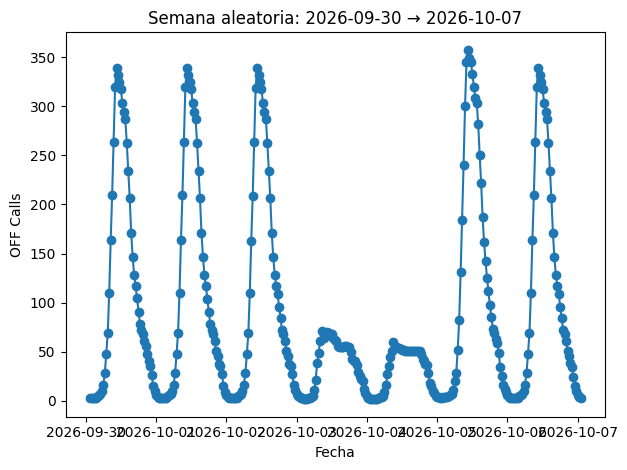

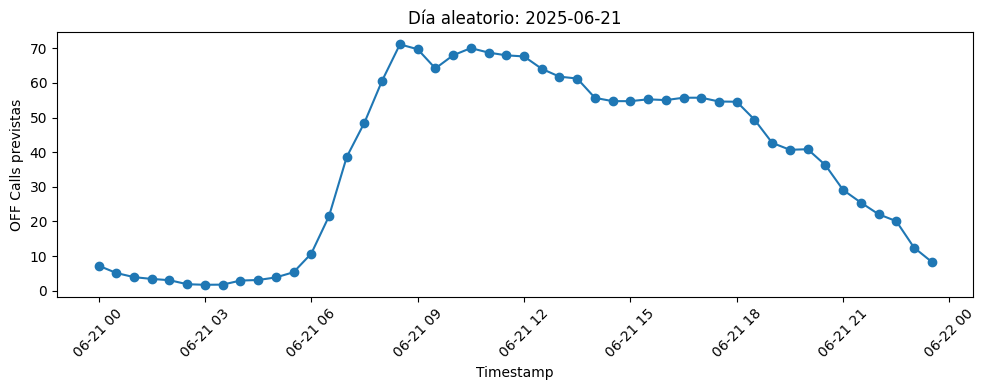

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Asegúrate de que tu columna de fecha es datetime
df_future['timestamp'] = pd.to_datetime(df_future['timestamp'])

# 2) Define rangos válidos de inicio para una semana (7 días)
min_date = df_future['timestamp'].min()
max_date_for_week = df_future['timestamp'].max() - pd.Timedelta(days=7)

# 3) Elige un inicio de semana al azar
random_start = df_future.loc[
    df_future['timestamp'].between(min_date, max_date_for_week),
    'timestamp'
].sample(1).iloc[0]
random_end = random_start + pd.Timedelta(days=7)

# 4) Filtra esa semana y dibújala
week = df_future[
    (df_future['timestamp'] >= random_start) &
    (df_future['timestamp'] < random_end)
]
plt.figure()
plt.plot(week['timestamp'], week['off_pred'], marker='o')
plt.title(f'Semana aleatoria: {random_start.date()} → {random_end.date()}')
plt.xlabel('Fecha')
plt.ylabel('OFF Calls')
plt.tight_layout()
plt.show()

# ——————————————————————————————————————————————

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Asegúrate de que la columna timestamp es datetime
df_future['timestamp'] = pd.to_datetime(df_future['timestamp'])

# Crea una columna con la fecha (sin hora)
df_future['date'] = df_future['timestamp'].dt.date

# Agrupa por día y selecciona solo aquellos con 48 registros
counts = df_future.groupby('date').size()
valid_days = counts[counts == 48].index

# Elige un día al azar de los válidos
random_day = np.random.choice(valid_days)

# Filtra los 48 intervalos de ese día
day_data = df_future[df_future['date'] == random_day]

# Grafica
plt.figure(figsize=(10, 4))
plt.plot(day_data['timestamp'], day_data['off_pred'], marker='o')
plt.title(f'Día aleatorio: {random_day}')
plt.xlabel('Timestamp')
plt.ylabel('OFF Calls previstas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

